## Visit analysis
The purpose of this notebook is to compare the mobility of users who live in the "treatment" (ZATs near new cable car) and "control" zones (similar ZATs but no new cable car). We will map the visits we computed in the `mobility_analysis` notebook to the treatment and control group information and point of interest (POIs) computed from google places.

In [1]:
from dotenv import load_dotenv
load_dotenv()

from plotting import * 
from preprocess import *
from analysis import *

import pandas as pd 
import numpy as np 
import skmob

# Access environment variables and define other necessary variables
data_dir = os.getenv('WORKING_DIR')
meta_dir = f'{data_dir}metadata/'
hw_dir = f'{data_dir}data/parquet/in_study_area/pass_qc/home_work_locs/'
sel_zat_home_locs_meta_fp = f'{meta_dir}selected_txt_control_home_locs_2200_0600_w_zats_txt_group_for_users_pass_qc.csv'
visit_dir=f'{data_dir}data/parquet/in_study_area/pass_qc/in_zats/visits/'
out_dir = f'{visit_dir}w_pois/'

### Adapt ZAT and home loc files to make them easier to work with/more intuitive
Read in ZATs file to add treatment and control ZAT information to the home locations file for the users living in the treatment or control ZATs

In [2]:
home_locs_file = f'{hw_dir}home/selected_txt_control_home_locs_2200_0600_w_zats_for_users_pass_qc.csv'
home_df = pd.read_csv(home_locs_file, usecols=['uid', 'lat_home', 'lng_home', 'Area', 'MUNCod', 'NOMMun', 'ZAT_home', 'UTAM_home', 'stratum'])
home_df = home_df.drop_duplicates(subset='uid')

Adapt the format of the ZATs file to make it easier to merge and work with and write out a new version

In [3]:
zats_tc_fp = f'{meta_dir}ZAT_treat_control.csv'
zats_tc = pd.read_csv(zats_tc_fp).astype('float64') 
ztreat = [i for i in list(zats_tc['ZATs Treatment group']) if str(i) != "nan"] 
zcontrol = [i for i in list(zats_tc['ZAT Control group']) if str(i) != "nan"] 
zsel = ztreat + zcontrol

ztreat_df = pd.DataFrame({'Group': 'Treatment', 'ZATs': ztreat})
zcontrol_df = pd.DataFrame({'Group': 'Control', 'ZATs': zcontrol})
zat_treat_control_df = pd.concat([ztreat_df, zcontrol_df])
zat_treat_control_df.to_csv(f'{meta_dir}ZAT_selected_txt_control.csv', index=False)

Load the new ZAT df and merge with home locations and write a home location file with the treatment group information

In [4]:
selected_zats = pd.read_csv(f'{meta_dir}ZAT_selected_txt_control.csv', index_col='ZATs')
#print(selected_zats.head())
home_df_w_tc = home_df.merge(selected_zats, left_on='ZAT_home', right_index=True)
print(len(home_df), len(home_df_w_tc))
#home_df_w_tc.to_csv(f'{meta_dir}selected_txt_control_home_locs_2200_0600_w_zats_txt_group_for_users_pass_qc.csv', index=False)

39652 39652


In [5]:
sel_zat_home_locs_meta = pd.read_csv(sel_zat_home_locs_meta_fp)

### Load shapefiles with the POI information 
There is one with a buffer of 15 meters around the google places POIs and one with 20 meters buffer.

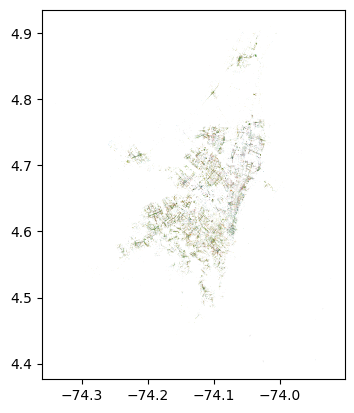

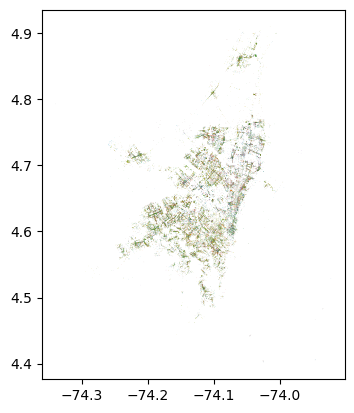

In [6]:
shp_name_poi_15m = 'POI_Buffer15m'
shapefile_poi_15m = f'{meta_dir}places/Buffer Shapefiles/{shp_name_poi_15m}.shp'
regions_gdf_poi15 = gpd.read_file(shapefile_poi_15m)
regions_gdf_poi15.plot(column='category')

shp_name_poi_20m = 'POI_Buffer20m'
shapefile_poi_20m = f'{meta_dir}places/Buffer Shapefiles/{shp_name_poi_20m}.shp'
regions_gdf_poi20 = gpd.read_file(shapefile_poi_20m)
regions_gdf_poi20.plot(column='category')

# for POIs with 15m Buffer
shp_name, gdf_from_shp = shp_name_poi_15m, regions_gdf_poi15

# for POIs with 20m Buffer
#shp_name, gdf_from_shp = shp_name_poi_20m, regions_gdf_poi20


### Load visits and map the visits to the POIs
Load the visit locations for users living within the treatment and control ZATs. Note that these are rough estimates and may need to be recomputed. 

In [ ]:
visit_durations=[20, 30, 60]

for i in tqdm(range(0,len(visit_durations)), desc=f'Mapping and writing user visits to POIs from {shp_name}'):
    stopping_time = visit_durations[i]
    visits_filename = f'users_living_in_sel_zat_visits_atleast_{stopping_time}min' # modify fp as needed, e.g. add _nodatafor_1440_minutes'
    visits_fp = f'{visit_dir}{visits_filename}.csv'
    outfilename = f'{visits_filename}_w_poi_from_{shp_name}_shp'
    visit_df = read_visits(visits_fp, uid_treat_group_info=sel_zat_home_locs_meta)
    visits_w_poi_df = calc_write_visit_pois(
        visit_df=visit_df, regions_gdf=gdf_from_shp, 
        cols_to_keep = (list(visit_df.columns) + ['name', 'dup', 'status', 'category', 'id', 'BUFF_DIST', 'ORIG_FID', 'Shape_Area']), 
        out_dir=out_dir, subdir_name=shp_name, outfilename=outfilename)

#### Some logs: 
**For the 15m Buffer**
- There were 3007082 visits in the file. 1157808 instances occured where visits mapped to named POIs (some visits may map to multiple POIs). Wrote data to users_living_in_sel_zat_visits_atleast_20min_w_poi_from_POI_Buffer15m_shp
- There were 2487677 visits in the file. 934178 instances occured where visits mapped to named POIs (some visits may map to multiple POIs). Wrote data to users_living_in_sel_zat_visits_atleast_30min_w_poi_from_POI_Buffer15m_shp
- There were 1861875 visits in the file. 643682 instances occured where visits mapped to named POIs (some visits may map to multiple POIs). Wrote data to users_living_in_sel_zat_visits_atleast_60min_w_poi_from_POI_Buffer15m_shp

**For the 20m Buffer**
- There were 3007082 visits in the file. 1967679 instances occured where visits mapped to named POIs (some visits may map to multiple POIs). Wrote data to users_living_in_sel_zat_visits_atleast_20min_w_poi_from_POI_Buffer20m_shp

- There were 2487677 visits in the file. 1583775 instances occured where visits mapped to named POIs (some visits may map to multiple POIs). Wrote data to users_living_in_sel_zat_visits_atleast_30min_w_poi_from_POI_Buffer20m_shp

- There were 1861875 visits in the file. 1089400 instances occured where visits mapped to named POIs (some visits may map to multiple POIs). Wrote data to users_living_in_sel_zat_visits_atleast_60min_w_poi_from_POI_Buffer20m_shp

#### Some logs for the files with the additional `_nodatafor_1440_minutes` filtering: 

**For the 15m Buffer**
- There were 2763819 visits in the file. 1080490 instances occured where visits mapped to named POIs (some visits may map to multiple POIs). Wrote data to users_living_in_sel_zat_visits_atleast_20min_nodatafor_1440_minutes_w_poi_from_POI_Buffer15m_shp

- There were 2242918 visits in the file. 856483 instances occured where visits mapped to named POIs (some visits may map to multiple POIs). Wrote data to users_living_in_sel_zat_visits_atleast_30min_nodatafor_1440_minutes_w_poi_from_POI_Buffer15m_shp

- There were 1613447 visits in the file. 564951 instances occured where visits mapped to named POIs (some visits may map to multiple POIs). Wrote data to users_living_in_sel_zat_visits_atleast_60min_nodatafor_1440_minutes_w_poi_from_POI_Buffer15m_shp

**For the 20m Buffer**
- There were 2763819 visits in the file. 1836594 instances occured where visits mapped to named POIs (some visits may map to multiple POIs). Wrote data to users_living_in_sel_zat_visits_atleast_20min_nodatafor_1440_minutes_w_poi_from_POI_Buffer20m_shp

- There were 2242918 visits in the file. 1452026 instances occured where visits mapped to named POIs (some visits may map to multiple POIs). Wrote data to users_living_in_sel_zat_visits_atleast_30min_nodatafor_1440_minutes_w_poi_from_POI_Buffer20m_shp

- There were 1613447 visits in the file. 955859 instances occured where visits mapped to named POIs (some visits may map to multiple POIs). Wrote data to users_living_in_sel_zat_visits_atleast_60min_nodatafor_1440_minutes_w_poi_from_POI_Buffer20m_shp


### Load the visits and look at how many mapped to one or more POIs, group them by POI category

In [7]:
outfilename = f'users_living_in_sel_zat_visits_atleast_60min_w_poi_from_{shp_name}_shp'
vists_w_poi_df_fp = f'{out_dir}{shp_name}/{outfilename}.csv'
visits_w_poi_df = pd.read_csv(vists_w_poi_df_fp)
visits_w_named_pois, visits_w_more_than_one_named_poi, grouped_category_proportions = calc_group_poi_visits(visits_w_poi_df)
visits_w_named_pois.head()

The number of total visits is 2133235, with 643682 POIs mapped.
The number of visits that map to at least one POI is 372344, and 145792 map to multiple POIs.
The percentage of visits with more than one assigned POI is: 39.1551898244634


,uid,lat_visit,lng_visit,datetime,geohash,horizontal_accuracy,index_from_shp,LOCNombre,UTAMNombre,leaving_datetime,ZAT_home,Group,name,dup,status,category,id,BUFF_DIST,ORIG_FID,Shape_Area
0,00002eec-9e3e-4e4d-9822-4e4858a0de0c,4.566298,-74.131795,2019-01-04 20:33:59-05:00,d2g3cp6bs289,7.0,236,TUNJUELITO,TUNJUELITO,2019-01-08 14:38:31-05:00,657.0,Treatment,CITY FASHION,0.0,OPERATIONAL,cloths,15631.0,15.0,11094.0,5.747389e-08
2,00002eec-9e3e-4e4d-9822-4e4858a0de0c,4.566218,-74.131805,2019-01-08 18:24:27-05:00,d2g3cp6b5sz3,22.0,236,TUNJUELITO,TUNJUELITO,2019-01-09 17:27:33-05:00,657.0,Treatment,Droguería La Cincuenta y Cinco,0.0,OPERATIONAL,pharms,38458.0,15.0,26546.0,5.747386e-08
4,00002eec-9e3e-4e4d-9822-4e4858a0de0c,4.566277,-74.131790,2019-01-09 20:56:35-05:00,d2g3cp6begth,10.0,236,TUNJUELITO,TUNJUELITO,2019-01-10 13:24:32-05:00,657.0,Treatment,CITY FASHION,0.0,OPERATIONAL,cloths,15631.0,15.0,11094.0,5.747389e-08
5,00002eec-9e3e-4e4d-9822-4e4858a0de0c,4.566277,-74.131790,2019-01-09 20:56:35-05:00,d2g3cp6begth,10.0,236,TUNJUELITO,TUNJUELITO,2019-01-10 13:24:32-05:00,657.0,Treatment,Droguería La Cincuenta y Cinco,0.0,OPERATIONAL,pharms,38458.0,15.0,26546.0,5.747386e-08
7,00002eec-9e3e-4e4d-9822-4e4858a0de0c,4.566281,-74.131790,2019-01-10 19:59:57-05:00,d2g3cp6bs20d,8.0,236,TUNJUELITO,TUNJUELITO,2019-01-13 10:24:44-05:00,657.0,Treatment,CITY FASHION,0.0,OPERATIONAL,cloths,15631.0,15.0,11094.0,5.747389e-08


In [8]:
grouped_cat_prop_csv_fp = f'{out_dir}{outfilename}_grouped_by_txt_category_proportions'
grouped_category_proportions.to_csv(f'{grouped_cat_prop_csv_fp}.csv')
grouped_category_proportions.head()

proportion
Group   category               
Control restaurants    0.254262
        cafes          0.102130
        cloths         0.079207
        hgs            0.078723
        pharms         0.073632

### Plot proportion of category of POI visits for control and treatment ZATs

In [9]:
from plotting import *

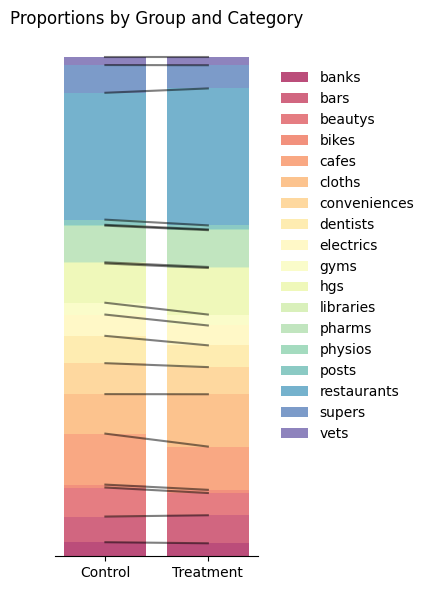

In [13]:
plot_dir = f'{data_dir}figures/'
plotfilename = f'{plot_dir}users_living_in_sel_zat_visits_atleast_60min_w_poi_from_{shp_name}_shp_grouped_by_txt_category_proportions'
plot_stacked_bar_from_csv(f'{grouped_cat_prop_csv_fp}.csv', out_file=plotfilename, colormap='Spectral')